## **Import Libraries**

In [15]:
import sys
sys.path.insert(1, '../scripts')
import extended_model
import importlib
importlib.reload(extended_model)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import bisect

import itertools
from functools import reduce
from operator import mul
from scipy.stats import norm
import random

## **Observe model components one by one**

### Create belief networks

In [2]:
G_complete = extended_model.complete_belief_network(n_nodes=3, edge_values="default")
G_ER = extended_model.gnp_belief_network(n_nodes=3, prob=.3, seed=89)

In [3]:
gradient_colors = extended_model.weight_gradient_color_matching(n=3, c1='red', c2='blue')

for _ in [G_complete, G_ER]:
    extended_model.add_colors_to_edges(_, gradient_colors)

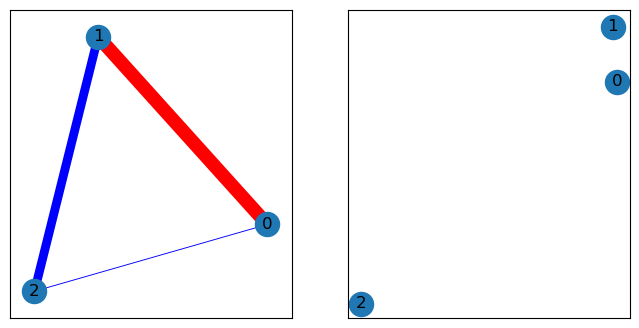

In [4]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

for i, g in zip([0,1], [G_complete, G_ER]):
    nx.draw_networkx(g, 
                    ax=axs[i], 
                    edge_color=[g.edges[e]['color'] for e in g.edges()],
                    width=[abs(g.edges[e]['belief'])*10 for e in g.edges()])


### Internal energy of individual i’s belief network:

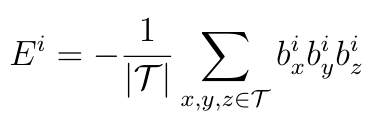

In [5]:
triads = extended_model.find_triads(G_complete)
triads

[[0, 1, 2]]

In [6]:
extended_model.triad_energy(G_complete, triads[0], weight_key="belief")

-0.04114562744568123

In [7]:
extended_model.internal_energy(G_complete)

0.04114562744568123

### Derivative of triad energy
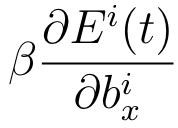

In [8]:
triads = extended_model.find_triads(G_complete)
triad = triads[0]
focal_edge = (0,1)
extended_model.derivative_triad_energy(G_complete, triad=triad, focal_edge=focal_edge)

0.04194990370096867

### Derivative of internal energy

In [9]:
focal_edge = (0,1)
extended_model.derivative_internal_energy(G_complete, focal_edge)

-0.04194990370096867

### Create a network of agents 

In [10]:
# Community social network
N = 100
mu = .1
M = 1000
seed = 89
#G, comm1, comm2 = extended_model.community_social_network(N=N, mu=mu, M=M, seed=seed)

# Erdos Renyi (random) Graph
p = .2
G = nx.gnp_random_graph(n=N, p=p, seed=seed)

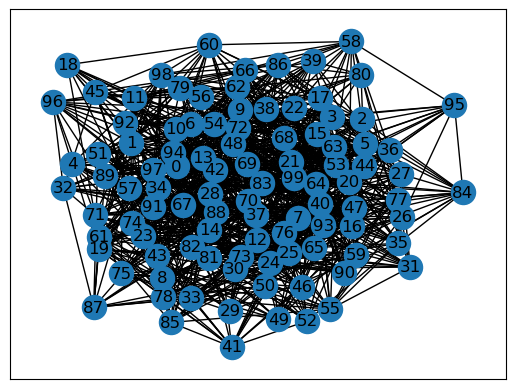

In [11]:
nx.draw_networkx(G)

### Embed belief networks

In [12]:
n_nodes = 3
belief_network_dict = {i:{'belief_network':extended_model.complete_belief_network(n_nodes=n_nodes, edge_values="default")} for i in range(N)}
nx.set_node_attributes(G, belief_network_dict)

### Interaction

Randomly choose a sender and receiver

In [13]:
sender, receiver, focal_edge = extended_model.choose_sender_receiver_belief(G)

The tendency of the receiver for internal coherence

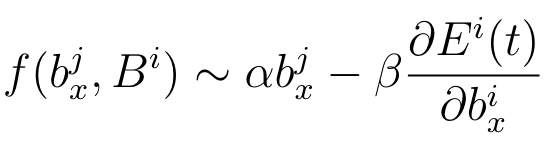

Make it stochastic

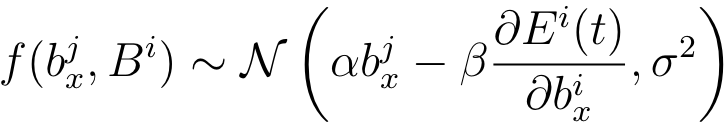

Update receiver's belief

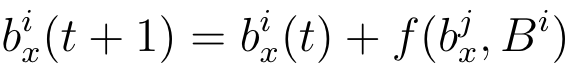

In [19]:
print([(G.nodes[sender]['belief_network'].edges[e], e) for e in G.nodes[sender]['belief_network'].edges()])

[({'belief': 0.7221056648636723}, (0, 1)), ({'belief': -0.7041608859177872}, (0, 2)), ({'belief': -0.019905658706160123}, (1, 2))]


In [16]:
b_i_plus_1 = extended_model.calculate_updated_weight(G, sender, receiver, focal_edge, alpha=1.5, beta=1)
print([(G.nodes[receiver]['belief_network'].edges[e], e) for e in G.nodes[receiver]['belief_network'].edges()])
print(b_i_plus_1)
extended_model.embed_b_i_plus_1_to_belief_network(G, receiver, focal_edge, b_i_plus_1)
[(G.nodes[receiver]['belief_network'].edges[e], e) for e in G.nodes[receiver]['belief_network'].edges()]

[({'belief': 0.8004474918070665}, (0, 1)), ({'belief': -0.5279155763136902}, (0, 2)), ({'belief': 0.8988636529770611}, (1, 2))]
1


[({'belief': 1}, (0, 1)),
 ({'belief': -0.5279155763136902}, (0, 2)),
 ({'belief': 0.8988636529770611}, (1, 2))]

## **Run the simulation**

In [20]:
from tqdm import tqdm

In [85]:
t % 100 ==0

False

In [281]:
t % per_interaction_to_track

0

In [282]:
t

77760

In [284]:
per_interaction_to_track = 10
track = {}

# Initialize the social network
N = 1000
p = .2
seed = 89
G = nx.gnp_random_graph(n=N, p=p, seed=seed)

# Embed the belief networks
n_nodes = 3
belief_network_dict = {i:{'belief_network':extended_model.complete_belief_network(n_nodes=n_nodes, edge_values="default")} for i in range(N)}
nx.set_node_attributes(G, belief_network_dict)
# Save the edge_list to use in the simulation
edge_list = [*belief_network_dict[0]['belief_network'].edges()]

# Simulate
T = N * n_nodes * 100

for t in tqdm(range(T+1)):
    
    # Calculate internal energies
    if t % per_interaction_to_track == 0:
        track[t] = {}
        beliefs = np.array([[G.nodes[n]['belief_network'].edges[e]['belief'] for e in edge_list] for n in G.nodes()])
        internal_energies = np.array([extended_model.internal_energy(G.nodes[n]['belief_network']) for n in G.nodes()])
        track[t]['internal_energies'] = internal_energies
        track[t]['beliefs'] = beliefs

        # Stopping criteria if all internal energies = -1 & nothing has changed from the last interaction
        if t > per_interaction_to_track:

            if all(np.array(internal_energies) == -1) & (sum(sum(track[[*track.keys()][-2]]['beliefs'] == track[[*track.keys()][-1]]['beliefs'])) == N * n_nodes):
                break

    if (t % N == 0) & (t > N):
        # this tracks whether an agent's internal energy got better or not
        track[t]['better_off'] = np.sign(track[t]['internal_energies'] - track[t - N]['internal_energies'])
    
    # Randomly choose a sender, receiver and focal edge
    sender, receiver, focal_edge = extended_model.choose_sender_receiver_belief(G)
    
    # Calculate the updated weight after agents interact
    b_i_plus_1 = extended_model.calculate_updated_weight(G, sender, receiver, focal_edge, alpha=1.5, beta=1)

    # Update the belief in the network
    extended_model.embed_b_i_plus_1_to_belief_network(G, receiver, focal_edge, b_i_plus_1)

 33%|███▎      | 100280/300001 [02:40<05:20, 623.24it/s]


In [304]:
sum([i<0 for i in track[t]['internal_energies'] - track[t - N]['internal_energies']])

3

In [187]:
def count_sign_check_agents(beliefs_array_new, beliefs_array_old, n_nodes):
    
    return sum([sum(a) != n_nodes for a in np.sign(beliefs_array_new) == np.sign(beliefs_array_old)])

In [271]:
np.array([sum(v['better_off']==-1) for v in [*track.values()][2:]]) - np.array([sum(v['better_off']==1) for v in [*track.values()][2:]])

array([2, 0, 2, ..., 0, 1, 0])

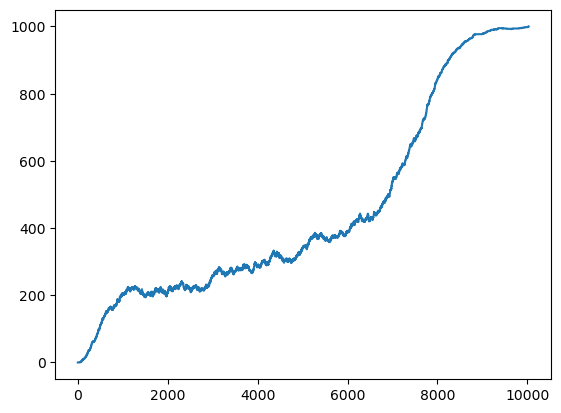

In [327]:
types_of_stable = np.array([[1,1,1], [-1,-1,1], [-1,1,-1], [1,-1,-1]])

In [382]:
len([v['beliefs'] for v in track.values()][-1])

1000

In [385]:
stable

array([ 1, -1, -1])

In [388]:
[v['beliefs'] for k,v in track.items()][2][126]

array([-0.85993453,  0.60523257, -1.        ])

In [415]:
[np.where(v['beliefs']-stable)==np.array([0,0,0]) for k,v in track.items()]

/tmp/ipykernel_2755506/2801177164.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  [np.where(v['beliefs']-stable)==np.array([0,0,0]) for k,v in track.items()]


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


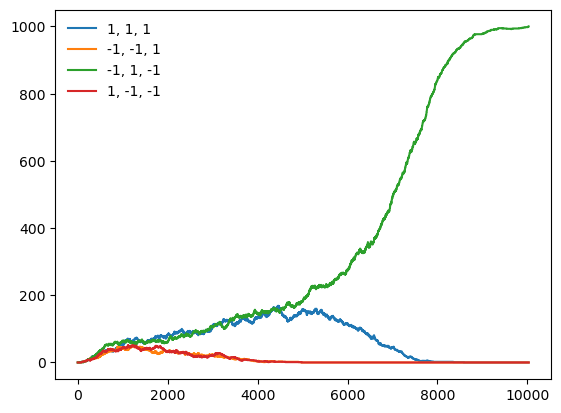

In [429]:
for stable in types_of_stable:
    plt.plot([sum(np.sum(v['beliefs']==stable, axis=1)==3) for v in track.values()],
            label=", ".join([str(i) for i in list(stable)]))
plt.legend(frameon=False)

In [369]:
[len(np.where(v['beliefs']==stable)[0]) for k,v in track.items()]

[0,
 0,
 1,
 2,
 4,
 7,
 9,
 12,
 12,
 13,
 14,
 14,
 15,
 16,
 19,
 22,
 24,
 27,
 30,
 31,
 31,
 36,
 36,
 39,
 39,
 44,
 46,
 46,
 50,
 51,
 52,
 53,
 56,
 58,
 59,
 61,
 62,
 63,
 65,
 67,
 70,
 74,
 73,
 75,
 77,
 79,
 83,
 85,
 87,
 89,
 91,
 90,
 91,
 91,
 93,
 95,
 97,
 100,
 100,
 101,
 104,
 105,
 108,
 111,
 110,
 111,
 112,
 115,
 117,
 117,
 119,
 121,
 121,
 124,
 126,
 129,
 131,
 131,
 132,
 136,
 138,
 143,
 145,
 148,
 152,
 156,
 157,
 157,
 161,
 164,
 164,
 166,
 168,
 172,
 173,
 175,
 175,
 180,
 182,
 183,
 185,
 187,
 190,
 190,
 193,
 196,
 197,
 198,
 198,
 198,
 200,
 201,
 204,
 207,
 207,
 207,
 209,
 210,
 210,
 211,
 212,
 214,
 217,
 220,
 220,
 223,
 225,
 228,
 227,
 230,
 233,
 235,
 237,
 237,
 238,
 238,
 239,
 240,
 244,
 247,
 246,
 249,
 254,
 254,
 253,
 254,
 256,
 258,
 259,
 257,
 259,
 259,
 258,
 259,
 261,
 262,
 264,
 266,
 268,
 269,
 272,
 274,
 274,
 277,
 278,
 279,
 279,
 280,
 280,
 280,
 282,
 282,
 285,
 287,
 288,
 289,
 289,
 2

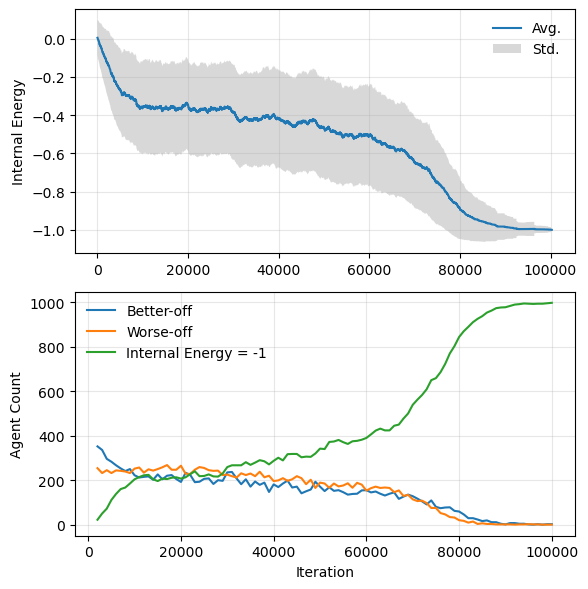

In [320]:
fig, axs = plt.subplots(2,1,figsize=(6,6))
mean_values = np.array([np.mean(v['internal_energies']) for v in track.values()])
std_values = np.array([np.std(v['internal_energies']) for v in track.values()])/2

x = [*track.keys()]

axs[0].plot(x, mean_values, label = 'Avg.')
axs[0].fill_between(x, mean_values-std_values, mean_values+std_values, facecolor='gray', alpha=0.3, label = 'Std.')

for sign, label in zip([-1,1], ['Better-off', 'Worse-off']):
    axs[1].plot([k for k,v in track.items() if 'better_off' in v.keys()],
                [sum(v['better_off']==sign) for k,v in track.items() if 'better_off' in v.keys()],
                label=label,
                )

axs[1].plot([k for k,v in track.items() if 'better_off' in v.keys()],
            [sum(v['internal_energies']==-1) for v in track.values() if 'better_off' in v.keys()],
            label='Internal Energy = -1')

for i, ylabel in zip([0, 1], ['Internal Energy', 'Agent Count']):
    axs[i].grid(alpha=.3)
    axs[i].set_ylabel(ylabel)
    axs[i].legend(frameon=False)

axs[i].set_xlabel('Iteration')

fig.tight_layout()
fig.show()